#Analyzing the NYC Subway Dataset
#Intro to Data Science: Final Project 1, Part 2  
#(Short Questions)
##Section 1. Statistical Test
Austin J. Alexander
***

##Import Directives and Initial DataFrame Creation

In [1]:
import inflect # for string manipulation
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

filename = '/Users/excalibur/py/nanodegree/intro_ds/final_project/improved-dataset/turnstile_weather_v2.csv'

# import data
data = pd.read_csv(filename)

##Functions for Getting, Mapping, and Plotting Data

In [2]:
entries_hourly_by_row = data['ENTRIESn_hourly'].values

In [3]:
def map_column_to_entries_hourly(column):
    instances = column.values # e.g., longitude_instances = data['longitude'].values
    
    # reduce
    entries_hourly = {} # e.g., longitude_entries_hourly = {}
    for i in np.arange(len(instances)): 
        if instances[i] in entries_hourly:
            entries_hourly[instances[i]] += float(entries_hourly_by_row[i])
        else:
            entries_hourly[instances[i]] = float(entries_hourly_by_row[i])
            
    return entries_hourly # e.g., longitudes, entries

In [4]:
def create_df(entries_hourly_dict, column1name):
    # e.g, longitude_df = pd.DataFrame(data=longitude_entries_hourly.items(), columns=['longitude','entries'])
    df = pd.DataFrame(data=entries_hourly_dict.items(), columns=[column1name,'entries'])
    
    return df # e.g, longitude_df

In [5]:
rain_entries_hourly = map_column_to_entries_hourly(data['rain'])
rain_df = create_df(rain_entries_hourly, 'rain')
rain_days = data[data['rain'] == 1]
no_rain_days = data[data['rain'] == 0]

In [6]:
def plot_box(sample1, sample2):
    plt.boxplot([sample2, sample1], vert=False)
    plt.title('NUMBER OF ENTRIES PER SAMPLE')
    plt.xlabel('ENTRIESn_hourly')
    plt.yticks([1, 2], ['Sample 2', 'Sample 1'])

    plt.show()

##Function for Basic Statistics

In [7]:
def describe_samples(sample1, sample2):
    size1, min_max1, mean1, var1, skew1, kurt1 = st.describe(sample1)
    size2, min_max2, mean2, var2, skew2, kurt2 = st.describe(sample2)

    med1 = np.median(sample1)
    med2 = np.median(sample2)

    std1 = np.std(sample1)
    std2 = np.std(sample2)

    print "Sample 1 (rainy days):\n  min = {0}, max = {1},\n  mean = {2:.2f}, median = {3}, var = {4:.2f}, std = {5:.2f}".format(min_max1[0], min_max1[1], mean1, med1, var1, std1)
    print "Sample 2 (non-rainy days):\n  min = {0}, max = {1},\n  mean = {2:.2f}, median = {3}, var = {4:.2f}, std = {5:.2f}".format(min_max2[0], min_max2[1], mean2, med2, var2, std2)

##Formulas Implemented  
(i.e., not included in modules/packages)

###Wendt's rank-biserial correlation $r$

$$r = 1 - \frac{2U}{n_{1}n_{2}}$$

###Cohen's $d$ (and pooled standard deviation $s$)

$$d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s}$$

$$s = \sqrt{\frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}}$$

##Class for Mann-Whitney U Test

In [8]:
class MannWhitneyU:
    
    def __init__(self,n):
        self.n = n
        self.num_of_tests = 1000
        self.sample1 = 0
        self.sample2 = 0
        
    def sample_and_test(self, plot, describe):
        self.sample1 = np.random.choice(rain_days['ENTRIESn_hourly'], size=self.n, replace=False)
        self.sample2 = np.random.choice(no_rain_days['ENTRIESn_hourly'], size=self.n, replace=False)
        ### the following two self.sample2 assignments are for testing purposes ###
        #self.sample2 = self.sample1 # test when samples are same
        #self.sample2 = np.random.choice(np.random.randn(self.n),self.n) # test for when samples are very different 
        
        if plot == True:
            plot_box(self.sample1,self.sample2)
        
        if describe == True:
            describe_samples(self.sample1,self.sample2)
        
        return st.mannwhitneyu(self.sample1, self.sample2)
    
    def effect_sizes(self, U):
        # Wendt's rank-biserial correlation
        r = (1 - np.true_divide((2*U),(self.n*self.n)))
        # Cohen's d
        s = np.sqrt(np.true_divide((((self.n-1)*np.std(self.sample1)**2) + ((self.n-1)*np.std(self.sample2)**2)), (self.n+self.n-2)))
        d = np.true_divide((np.mean(self.sample1) - np.mean(self.sample2)), s)
        return r,d

    def trial_series(self):
        success = 0
        U_values = []
        p_values = []
        d_values = []
        r_values = []
        for i in np.arange(self.num_of_tests):
            U, p = self.sample_and_test(False, False)
            r, d = self.effect_sizes(U)
            U_values.append(U)
            # scipy.stats.mannwhitneyu returns p for a one-sided hypothesis, 
            # so multiply by 2 for two-sided
            p_values.append(p*2)
            d_values.append(d)
            r_values.append(r)
            if p <= 0.05:
                success += 1

        print "n = {0}".format(self.n)
        print "average U value: {0:.2f}".format(np.mean(U_values))
        print "number of times p <= 0.05: {0}/{1} ({2}%)".format(success, self.num_of_tests, (np.true_divide(success,self.num_of_tests)*100))
        print "average p value: {0:.2f}".format(np.mean(p_values))
        print "average rank-biserial r value: {0:.2f}".format(np.mean(r_values))
        print "average Cohen's d value: {0:.2f}".format(np.mean(d_values))
        
        plt.hist(p_values, color='green', alpha=0.3)
        plt.show()

##Section 1. Statistical Test

<h3 id='1_1_a'>1.1.a Which statistical test did you use to analyse the NYC subway data?</h3>

The Mann-Whitney $U$ test was used to determine if there was a statistically significant difference between the number of reported entries on rainy and non-rainy occasions. This nonparametric test of the equality of two population medians from independent samples was used since the distribution of entries is non-normal (right-skewed) and their shape is the same, as seen visually via histograms, probability plots, and box plots, and as the result of the Shapiro-Wilk normality test (see <a href='IntroDS-ProjectOne-DataExploration-Supplement.ipynb#prep-for-stats' target='_blank'>Preparation for Statistical Tests</a>). However, since the sample sizes are so large, the parametric Welch's $t$-test likely could have been used (and, it was implemented for confirmation purposes, along with the nonparametric Wilcoxon signed-rank test; both agreed with the Mann-Whitney $U$ test results).

####Testing Average Values of $p$, $r$, and $d$ for Various Sample Sizes

n = 30
average U value: 395.37
number of times p <= 0.05: 92/1000 (9.2%)
average p value: 0.50
average rank-biserial r value: 0.12
average Cohen's d value: 0.05


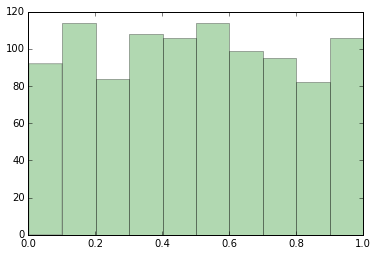

n = 100
average U value: 4651.27
number of times p <= 0.05: 143/1000 (14.3%)
average p value: 0.48
average rank-biserial r value: 0.07
average Cohen's d value: 0.07


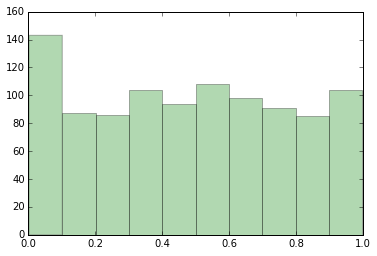

n = 500
average U value: 120289.09
number of times p <= 0.05: 191/1000 (19.1%)
average p value: 0.40
average rank-biserial r value: 0.04
average Cohen's d value: 0.06


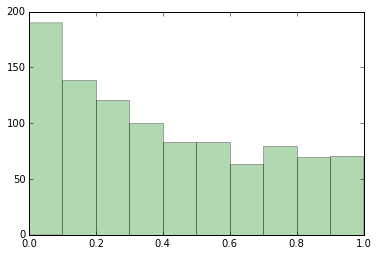

n = 1500
average U value: 1088803.02
number of times p <= 0.05: 437/1000 (43.7%)
average p value: 0.25
average rank-biserial r value: 0.03
average Cohen's d value: 0.06


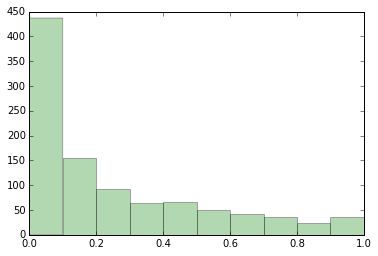

n = 3000
average U value: 4359194.71
number of times p <= 0.05: 703/1000 (70.3%)
average p value: 0.12
average rank-biserial r value: 0.03
average Cohen's d value: 0.06


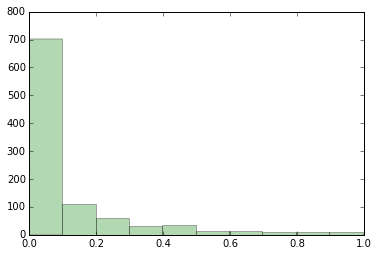

n = 5000
average U value: 12128284.78
number of times p <= 0.05: 886/1000 (88.6%)
average p value: 0.04
average rank-biserial r value: 0.03
average Cohen's d value: 0.06


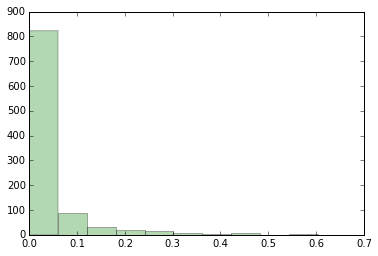

n = 9585
average U value: 44542035.04
number of times p <= 0.05: 999/1000 (99.9%)
average p value: 0.00
average rank-biserial r value: 0.03
average Cohen's d value: 0.06


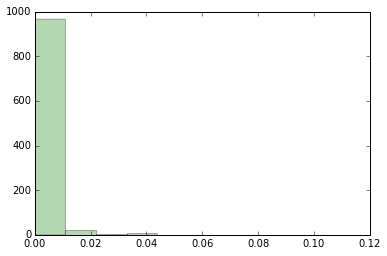

In [9]:
sample_sizes = [30, 100, 500, 1500, 3000, 5000, 9585]
for n in sample_sizes:
    MannWhitneyU(n).trial_series()

As witnessed above, when rainy and non-rainy days from the data set are considered populations (as opposed to samples themselves), it takes significantly large sample sizes from each population (e.g., $n = 3000$, which is more than $30\%$ of the total number of rainy days in the data set) to attain low $p$-values<sup>1</sup> frequently enough to reject the null hypothesis of the Mann-Whitney $U$ test<sup>2</sup> with the critical values proposed below.

Moreover, using Wendt's rank-biserial correlation $r$ and Cohen's $d$ to measure effect size, the relatively low average value of $r$<sup>3</sup> and the low average value of $d$<sup>4</sup> both suggest that the difference between the two samples (and, thus, the two populations) is trivial, even though, according to the Mann-Whitney U test, the difference appears to be statistically signficant (and only then with extremely large samples)<sup>5</sup>. In other words, statistical significance $\neq$ practical significance.

#####Notes
<sup>1</sup> Identical samples would produce a large $p$ (e.g., $p \approx 0.49$); extremely different samples would produce a very small number (e.g., $p \approx 0$).

<sup>2</sup> Identical samples would produce $U = \frac{n^{2}}{2}$ (e.g., when $n = 450$, $U = 101250$); extremely different samples can produce a $U$ that is orders of magnitude smaller (e.g., when $n = 450$, possibly $U = 1293$).

<sup>3</sup> For very different samples, $r \rightarrow 1$; in the above tests, as $n$ increases, $r \rightarrow 0$.  

<sup>4</sup> For very different samples, $d \rightarrow 1$; in the above tests, as $n$ increases, $d$ tends to remain constant, $d \approx 0.06$, even when the sample size is extremely large. $d$ is interpreted as the difference in the number of standard deviations.

<sup>5</sup> On the issue of $p$-values and large data sets, see Lin, M., Lucas, H.C., and Shmueli, G. Research Commentary—Too big to fail: Large samples and the P-value problem. *Inf. Syst. Res.* 2013; 24: 906–917. PDF <a href='http://www.galitshmueli.com/system/files/Print%20Version.pdf' target='_blank'>here</a>.

<h3 id='1_1_b'>1.1.b Did you use a one-tail or a two-tail P value?</h3>

A two-tail $p$-value was selected since an appropriate initial question, given the results of the <a href='IntroDS-ProjectOne-DataExploration-Supplement.ipynb#weather-related' target='_blank'>Weather-Related Data</a> section of the *DataExploration* supplement, is simply whether or not there is a statistically significant difference between the populations (i.e., not whether one population is statistically-significantly greater than another).

<h3 id='1_1_c'>1.1.c What is the null hypothesis?</h3>

In [10]:
print "Shape of rainy-days data:" +str(rain_days.shape)
N = rain_days.shape[0]
print "N = " + str(N)
print "0.05 * N = " + str(0.05 * N)

Shape of rainy-days data:(9585, 27)
N = 9585
0.05 * N = 479.25


The Mann-Whitney $U$ test is a nonparametric test of the null hypothesis that the distributions of two populations are the same.

To verify the assumption that the simple, randomly sampled values are independent, the sample sizes should be less than $5\%$ of the population sizes ($n \lt 0.05N$). Since the maximum number of rainy days is $9585$ ($N = 9585$), a reasonable sample size for each group would be $450$ ($n = 450$). 

**Null Hyptohesis**  
$H_{0}$: $M_{1} = M_{2}$ or $H_{0}$: $M_{1} - M_{2} = 0$

**Alternate Hypothesis**   
$H_{1}$: $M_{1} \neq M_{2}$ or $H_{1}$: $M_{1} - M_{2} \neq 0$

A $95\%$ level of confidence would suggest that $95\%$ of samples would produce similar statistical results.

For a $95\%$ level of confidence, the level of significance (i.e., the probability of making a Type I error)  $\alpha = (1 - 0.05) \cdot 100\% = 0.05$.

<h3 id='1_1_d'>1.1.d What is your p-critical value?</h3>

$p \leq 0.05$

####Gather New Samples and Perform Statistical Test

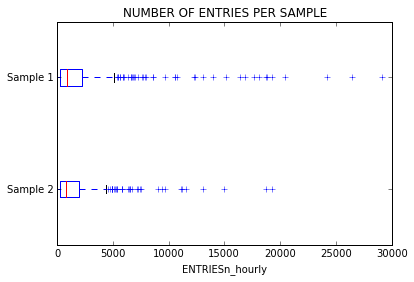

Sample 1 (rainy days):
  min = 0.0, max = 29096.0,
  mean = 2094.35, median = 877.5, var = 13978629.51, std = 3734.64
Sample 2 (non-rainy days):
  min = 0.0, max = 19235.0,
  mean = 1561.55, median = 791.0, var = 5372640.58, std = 2315.32

Mann-Whitney U test results:
n = 450
U = 96821.5
p = 0.13
rank-biserial r value: 0.04
Cohen's d value: 0.17


In [11]:
n = 450
mwu = MannWhitneyU(n)
U, p = mwu.sample_and_test(True,True)
r, d = mwu.effect_sizes(U)

print "\nMann-Whitney U test results:"
print "n = {0}".format(n)
print "U = {0}".format(U)
print "p = {0:.2f}".format(np.mean(p))
print "rank-biserial r value: {0:.2f}".format(np.mean(r))
print "Cohen's d value: {0:.2f}".format(np.mean(d))

<h3 id='1_3'>1.3 What results did you get from this statistical test?</h3>

[ N.B. The following values will change each time this notebook is run; however, the final results should not differ. ]

$p = 0.34$

**Sample 1 (rainy days)**   
$\bar{x}_{1} = 1805.17$, $M_{1} = 922.5$

**Sample 2 (non-rainy days)**  
$\bar{x}_{2} = 1733.25$, $M_{2} = 921.0$

<h3 id='1_4'>1.4 What is the significance and interpretation of these results?</h3>

####Statistical-Test Summary and Conclusion

The difference between the number of entries on rainy and non-rainy days ($n_{1} = n_{2} = 450$) from the data set is not statistically significant based on a two-independent-sample Mann-Whitney $U$ test using scipy.stats.mannwhitneyu ($U$ is extremely high [closer to its max value, $U = 101250$, than its min value] and $p$ is signicantly greater than the proposed critical value $0.05$). In addition, Wendt's rank-biserial correlation $r$ and Cohen's $d$ both indicate an essentially non-existent effect size.

Thus, there does not appear to be either a statistical or practical difference between rainy days and non-rainy days.